In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import glob
import numpy as np
from sten import Sten
from matplotlib.image import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm, trange

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def update_progress(max_epoch, epoch, progress, episode):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Episode {0}, Progress: [{1}] {2:.1f}%, Epoch {3}/{4}".format(episode, "=" * block + "." * (bar_length - block), progress * 100, epoch, max_epoch)
    print(text)

In [4]:
def generate_images(generator_g, generator_f, cover_imgs, hidden_imgs, encoded_imgs, decoded_imgs, save_name):
    fig, axs = plt.subplots(len(cover_imgs), 6, figsize=(25,25))
    cols = ["Cover", "Hidden", "Encoded", "Decoded", "Predicted Generator G", "Predicted Generator F"]
    for x in range(len(cover_imgs)):
        predicted_g = generator_g.predict(np.asarray([encoded_imgs[x]]))
        predicted_f = generator_f.predict(np.asarray([predicted_g[0]]))
        display_list = [cover_imgs[x], hidden_imgs[x], encoded_imgs[x], decoded_imgs[x], predicted_g[0], predicted_f[0]]
        [axs[x, y].imshow(display_list[y] * 0.5 + 0.5) for y in range(6)]
    [ax.set_title(col) for ax, col in zip(axs[0], cols)]
    [axi.set_axis_off() for axi in axs.ravel()]
    fig.tight_layout()
    plt.show()
    fig.savefig(save_name)

In [5]:
def discriminator_loss(a, generated):
    a_loss = loss_obj(tf.ones_like(a), a)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = a_loss + generated_loss
    return total_disc_loss * 0.5

In [6]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [7]:
def calc_cycle_loss(a_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(a_image - cycled_image))
    return LAMBDA * loss1

In [8]:
def identity_loss(a_image, same_image):
    loss = tf.reduce_mean(tf.abs(a_image - same_image))
    return LAMBDA * 0.5 * loss

In [9]:
@tf.function
def train_step(a_x, a_y):
    with tf.GradientTape(persistent=True) as tape:
    
        fake_y = generator_g(a_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(a_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(a_x, training=True)
        same_y = generator_g(a_y, training=True)

        disc_a_x = discriminator_x(a_x, training=True)
        disc_a_y = discriminator_y(a_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(a_x, cycled_x) + calc_cycle_loss(a_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(a_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(a_x, same_x)

        disc_x_loss = discriminator_loss(disc_a_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_a_y, disc_fake_y)
  
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [10]:
EPOCHS = 100
STEPS_PER_EPOCH = 10
LAMBDA = 10
SAVE_RATE = 10

In [11]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [12]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [14]:
# checkpoint_path = "checkpoints/train_sten"

# ckpt = tf.train.Checkpoint(generator_g=generator_g,
#                            generator_f=generator_f,
#                            discriminator_x=discriminator_x,
#                            discriminator_y=discriminator_y,
#                            generator_g_optimizer=generator_g_optimizer,
#                            generator_f_optimizer=generator_f_optimizer,
#                            discriminator_x_optimizer=discriminator_x_optimizer,
#                            discriminator_y_optimizer=discriminator_y_optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

In [15]:
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [16]:
# STEN_X = 8
# for epoch in trange(EPOCHS, desc="Epochs"):
#     start = time.time()
#     for x in trange(STEPS_PER_EPOCH, desc="Steps per Epoch"):
#         try:
#             set_1 = np.random.randint(1,11)
#             set_2 = np.random.randint(1,6)
#             name = str(set_1) + '_' + str(set_2)
#             encoded = np.load(os.getcwd() + "/encodedArray/bit_{0}/{1}.npy".format(STEN_X, name))
#             decoded = np.load(os.getcwd() + "/decodedArray/bit_{0}/{1}.npy".format(STEN_X, name))
#             train_step(np.asarray([encoded/255.0], dtype='float32'), np.asarray([decoded/255.0], dtype='float32'))
#         except:
#             print("Error")

# cover_imgs = np.empty((0, 256, 256, 3))
# hidden_imgs = np.empty((0, 256, 256, 3))
# encoded_imgs = np.empty((0, 256, 256, 3))
# decoded_imgs = np.empty((0, 256, 256, 3))
# for _ in range(5):
#     set_1 = np.random.randint(1,11)
#     set_2 = np.random.randint(1,6)
#     name = str(set_1) + '_' + str(set_2)
#     cover = mpimg.imread(os.getcwd() + "/data/set1/{0}.jpg".format(set_1)) / 255.0
#     hidden = mpimg.imread(os.getcwd() + "/data/set2/{0}.jpg".format(set_2)) / 255.0
#     encoded = np.load(os.getcwd() + "/encodedArray/bit_{0}/{1}.npy".format(STEN_X, name)) / 255.0
#     decoded = np.load(os.getcwd() + "/decodedArray/bit_{0}/{1}.npy".format(STEN_X, name)) / 255.0
#     cover_imgs = np.row_stack((cover_imgs, np.asarray([cover])))
#     hidden_imgs = np.row_stack((hidden_imgs, np.asarray([hidden])))
#     encoded_imgs = np.row_stack((encoded_imgs, np.asarray([encoded])))
#     decoded_imgs = np.row_stack((decoded_imgs, np.asarray([decoded])))
    
# generate_images(generator_g, generator_f, cover_imgs, hidden_imgs, encoded_imgs, decoded_imgs, "cycle_sten_{}.png".format(STEN_X))

# # checkpoint_path = "checkpoints/cycle_gan_{0}".format(STEN_X)
# # ckpt = tf.train.Checkpoint(generator_g=generator_g,
# #                            generator_f=generator_f,
# #                            discriminator_x=discriminator_x,
# #                            discriminator_y=discriminator_y,
# #                            generator_g_optimizer=generator_g_optimizer,
# #                            generator_f_optimizer=generator_f_optimizer,
# #                            discriminator_x_optimizer=discriminator_x_optimizer,
# #                            discriminator_y_optimizer=discriminator_y_optimizer)
# # ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# # if ckpt_manager.latest_checkpoint:
# #     ckpt.restore(ckpt_manager.latest_checkpoint)
# #     print ('Latest checkpoint restored!!')

# # ckpt_manager.save()

Latest checkpoint restored!!


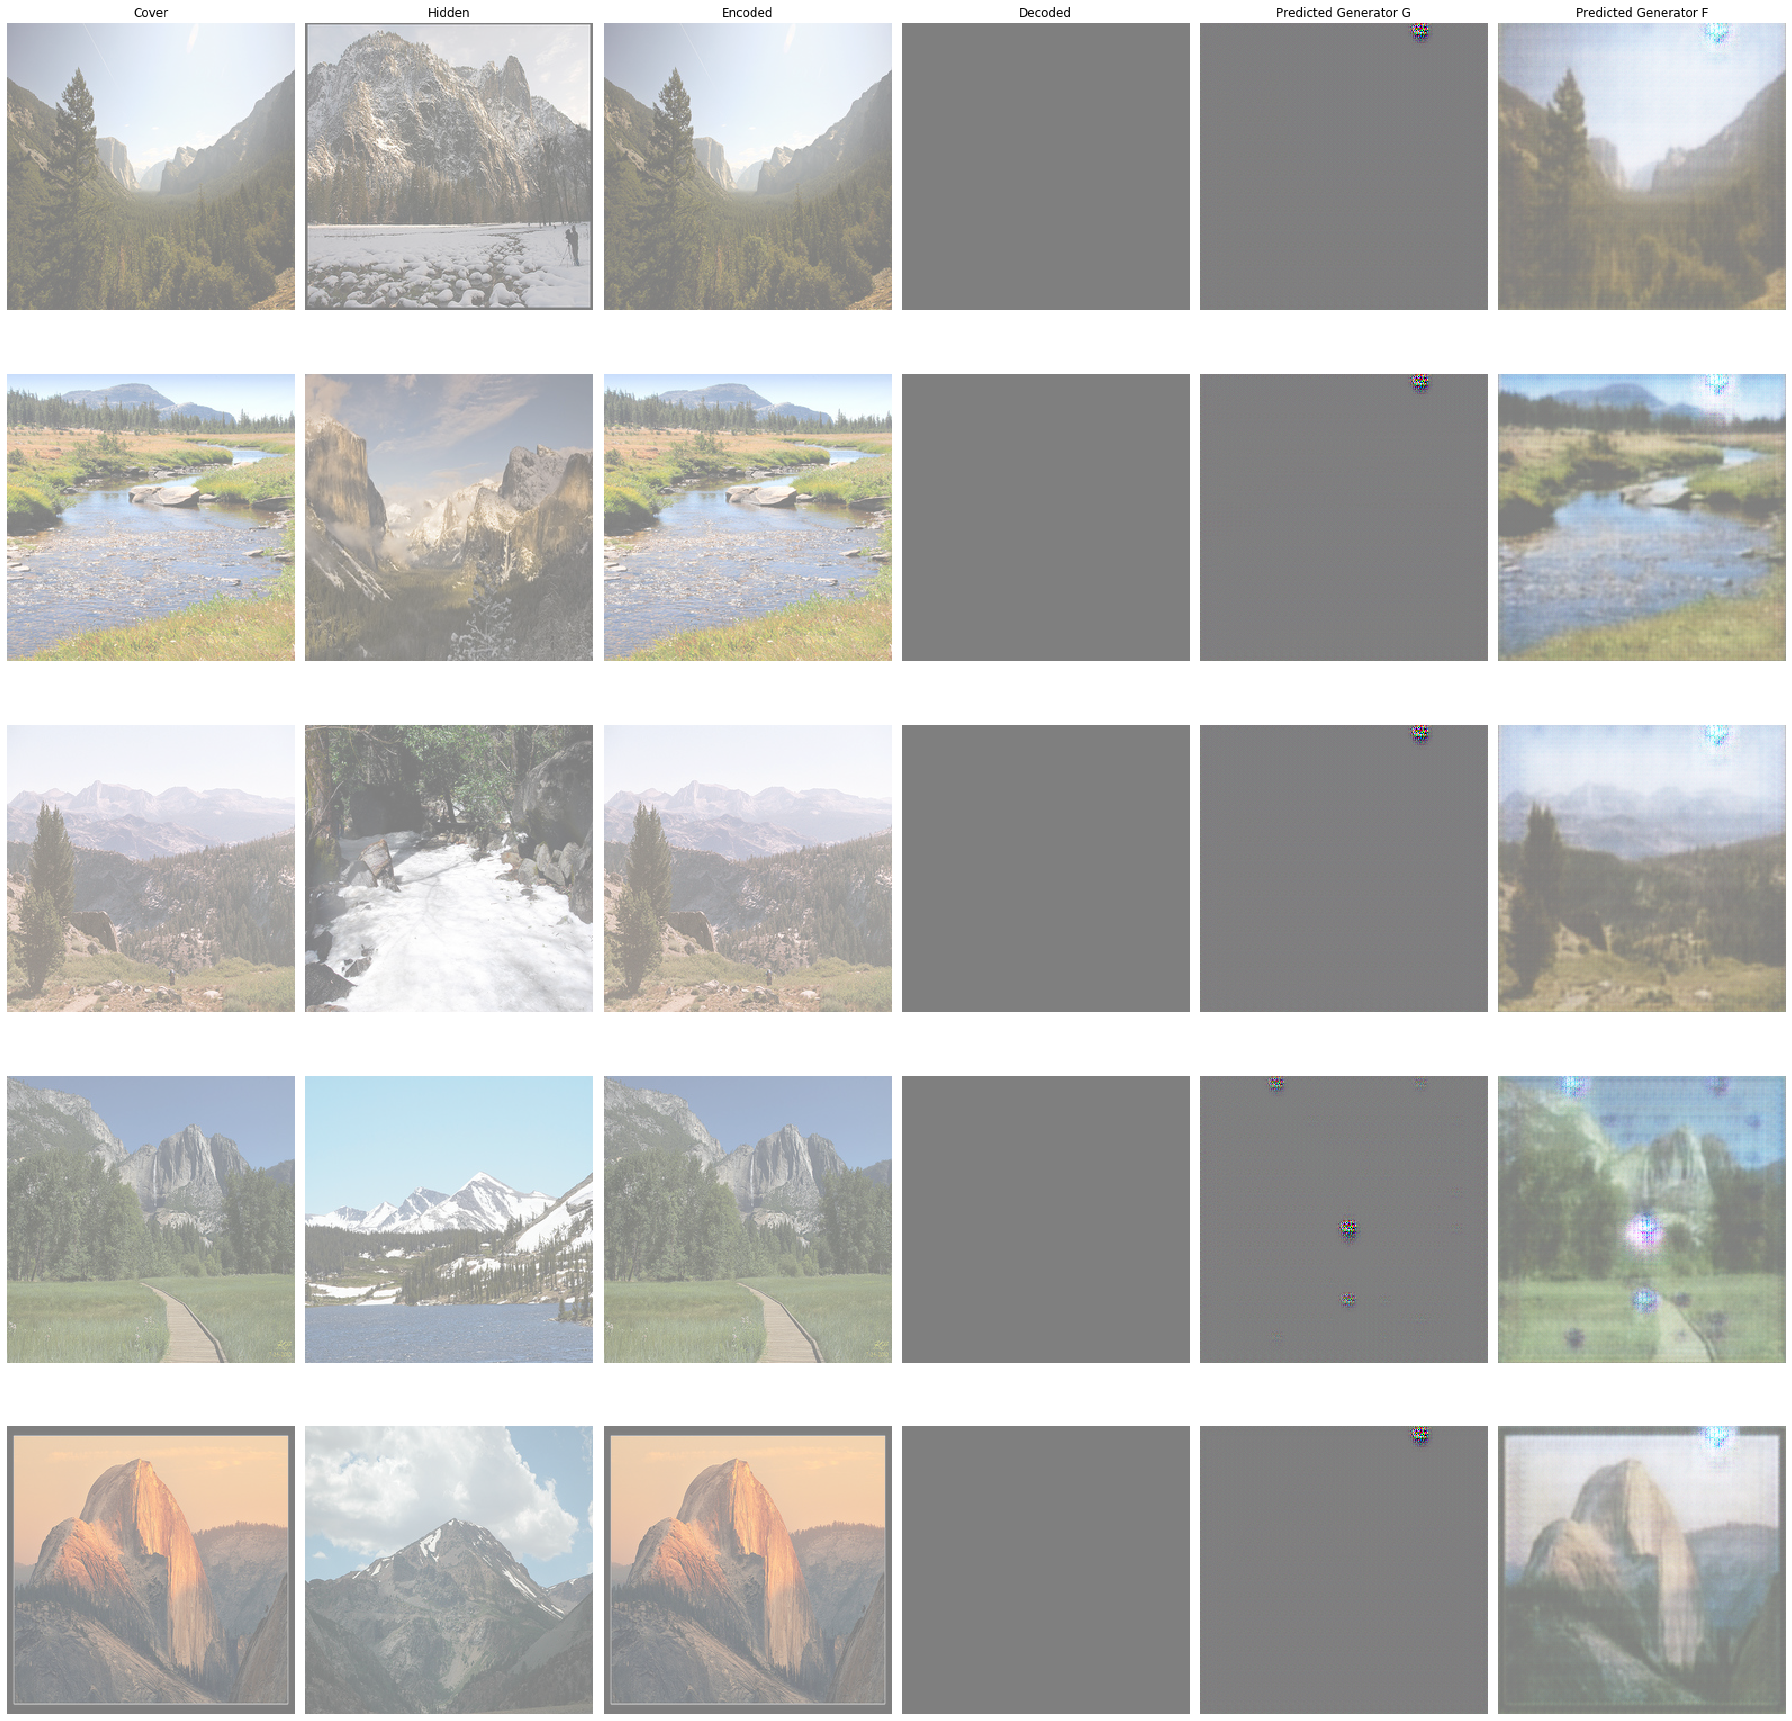

In [17]:
STEN_X = 0

checkpoint_path = "checkpoints/cycle_gan_{0}".format(STEN_X)
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

cover_imgs = np.empty((0, 256, 256, 3))
hidden_imgs = np.empty((0, 256, 256, 3))
encoded_imgs = np.empty((0, 256, 256, 3))
decoded_imgs = np.empty((0, 256, 256, 3))
for x in range(5):
    set_1 = x+10
    set_2 = x+6
    name = str(set_1) + '_' + str(set_2)
    cover = mpimg.imread(os.getcwd() + "/data/set1/{0}.jpg".format(set_1)) / 255.0
    hidden = mpimg.imread(os.getcwd() + "/data/set2/{0}.jpg".format(set_2)) / 255.0
    encoded = np.load(os.getcwd() + "/encodedArray/bit_{0}/{1}.npy".format(STEN_X, name)) / 255.0
    decoded = np.load(os.getcwd() + "/decodedArray/bit_{0}/{1}.npy".format(STEN_X, name)) / 255.0
    cover_imgs = np.row_stack((cover_imgs, np.asarray([cover])))
    hidden_imgs = np.row_stack((hidden_imgs, np.asarray([hidden])))
    encoded_imgs = np.row_stack((encoded_imgs, np.asarray([encoded])))
    decoded_imgs = np.row_stack((decoded_imgs, np.asarray([decoded])))
    
generate_images(generator_g, generator_f, cover_imgs, hidden_imgs, encoded_imgs, decoded_imgs, "cycle_sten_new_{}.png".format(STEN_X))